# EDA - Walmart - preprocessing
> # index
### 1. 데이터 불러오기 및 함수 호출
### 2. 사전 데이터정제 및 garbage값 제거 (근거 간략요약)
    0) 3년기간동안 units가 모두 = 0 인 값 제거(존재하지않는 아이템값은 0이라고 가정한다)
    2) 데이터열 자료형 최적화
    3) 날씨코드구분
    4) 전체데이터 조합
    5) 날짜분할(년,월,일), 온도차, 컬럼생성
### 3. 데이터 column간 유사성/상관수준 비교
### 4. 병합
    1)  
    2)
    3)
### 5. 상세분석
### 6. likelihood함수의 변수삽입
    
### 부록 : 데이터 정제 근거자료

---
# 1. 데이터 불러오기 및 함수호출=========================



In [2]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정

%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import pandas_profiling as pdp

C:\Users\creal\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
#전체기후날씨데이터(weather.csv) 불러오기--------------------------
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

In [5]:
# ★ 함수선언 ------------------------------------------------------
#-------날씨요소기준// 날짜-스테이션 데이터 도출함수
def weather_pivot(column_name):

    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 스테이션별 피봇팅(테이블)
    station_value = station_itm.pivot("date","station_nbr",column_name)
    station_table = station_value.apply(pd.to_numeric, errors = 'coerce')

    return station_table
    

#--------날씨요소기준// 날짜별 스테이션(숫자형)날씨요소 평균 도출함수---------
def weather_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["date","station_nbr",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
    avg_df = avg_df.apply(pd.to_numeric, errors = 'ignore')

    return avg_df


#--------날씨요소기준// 스테이션-전체날짜 날씨요소평균 도출함수---------
def station_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],np.NaN) #--특정문자 NaN으로 변환
    temp_df = temp_df.replace(["T","  T"],0.005)
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    station_avg = station_itm.pivot_table(column_name,["station_nbr"], aggfunc=np.mean)
    station_avg = station_avg.apply(pd.to_numeric, errors = 'ignore')
    
    return station_avg

#=============================================================================

#------★★완전체 형변환 함수(M,T,__T,None)==> 있는열도 변환 가능
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            continue 
        df = df.replace(["M",None],np.NaN)
        df = df.replace(["T","  T"],0.005)
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df



In [6]:
#weather_p에 사전정제자료 삽입(codesum은 추가정제필요)
weather_p = type_change_numeric(weather,["station_nbr","codesum","date"])
weather_p["date"] = pd.to_datetime(weather_p["date"])

In [7]:
weather_p.dtypes

station_nbr             int64
date           datetime64[ns]
tmax                  float64
tmin                  float64
tavg                  float64
depart                float64
dewpoint              float64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
snowfall              float64
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
dtype: object

---
# 2. 사전 데이터정제 및 Garbage값 제거===================

In [8]:
# 0) units = 0 인값 제거한 데이터프레임 만들기
store_df = store_data[store_data["units"]!=0]

In [9]:
# 1) 데이터 형변환(날짜 및 숫자)
import time

store_df["date"] = pd.to_datetime(store_df["date"])
weather["date"] = pd.to_datetime(weather["date"])

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [10]:
# 4) 전체데이터 조합 merge
#- 1. store_data에 스테이션 넘버 부여
result_df = store_df.merge(map_key, left_on="store_nbr", right_on="store_nbr" )
cols = ['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units']
new_df = result_df[cols] #열 위치변경된 것들
#- 2. 종합세팅
all_set = new_df.merge(weather_p, left_on=["date","station_nbr"], right_on=["date","station_nbr"] )

In [11]:
# 데이터타입 날짜화 및 int화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
all_set["date"]=all_set["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
temp_df = type_change_numeric(all_set,["date","store_nbr","item_nbr","units","station_nbr","codesum"])

In [12]:
master = all_set.sort_values(["date","store_nbr","item_nbr"])

In [13]:
master['year'] = master['date'].dt.year
master['month'] = master['date'].dt.month
master['day'] = master['date'].dt.day
master['DOW']=master['date'].dt.dayofweek

In [20]:
master.tail()

,date,store_nbr,station_nbr,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,DOW
35757,2014-10-31,44,12,5,47,75.0,60.0,68.0,NaN,53.0,...,0.0,29.8,29.85,7.0,32.0,7.5,2014,10,31,4
35758,2014-10-31,44,12,68,39,75.0,60.0,68.0,NaN,53.0,...,0.0,29.8,29.85,7.0,32.0,7.5,2014,10,31,4
35759,2014-10-31,44,12,94,1,75.0,60.0,68.0,NaN,53.0,...,0.0,29.8,29.85,7.0,32.0,7.5,2014,10,31,4
77759,2014-10-31,45,16,9,10,53.0,34.0,44.0,NaN,35.0,...,0.0,29.9,29.99,4.5,3.0,5.3,2014,10,31,4
77760,2014-10-31,45,16,26,1,53.0,34.0,44.0,NaN,35.0,...,0.0,29.9,29.99,4.5,3.0,5.3,2014,10,31,4


---
# 3. 데이터 column간 유사성, 상관성 분석

In [14]:
#----------이제 특정 함수를 써보자!

#1. 이슬점온도
station_dewpoint = weather_pivot("dewpoint")
station_dewpoint_avg = weather_mean("dewpoint")

#2. 하루평균온도
station_temp = weather_pivot("tavg")
station_temp_avg = weather_mean("tavg")

#3. 하루평균 바람세기
station_speed = weather_pivot("avgspeed")
station_speed_avg = weather_mean("avgspeed")
station_speed_eachavg = station_mean("avgspeed")

#4. 기압도
station_pressure = weather_pivot("stnpressure")
station_pressure_avg = weather_mean("stnpressure")
station_pressure_eachavg = station_mean("stnpressure") #개별 스테이션별 평균 기압

#5. 이상기후온도
station_depart = weather_pivot("depart")
station_depart_avg = weather_mean("depart")

#6. 적셜량
station_snow = weather_pivot("snowfall")
station_snow_avg = weather_mean("snowfall")
station_snow_eachavg = station_mean("snowfall") #개별 스테이션별 평균 적설량

#7. 강우량
station_rain = weather_pivot("preciptotal")
station_rain_avg = weather_mean("preciptotal")
station_rain_eachavg = station_mean("preciptotal") #개별 스테이션별 평균 적설량

#8. 바람방향
station_dir = weather_pivot("resultdir")
station_dir_avg = weather_mean("resultdir")
station_dir_eachavg = station_mean("resultdir")
                           

### - 전체기준 X아이템넘버/Y판매갯수 추이 

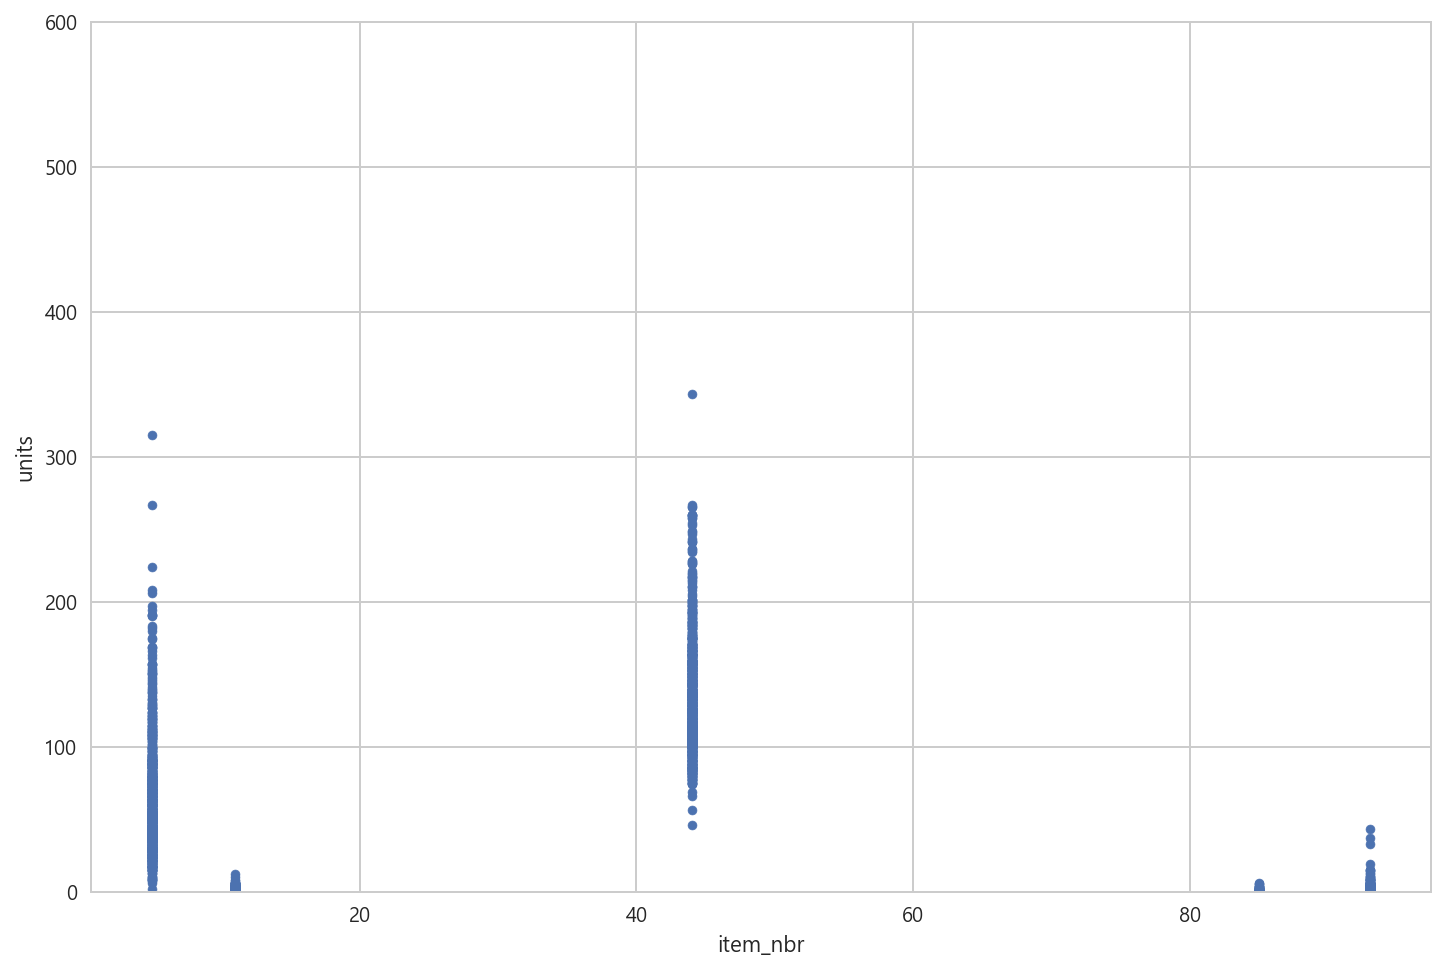

In [42]:
#각 아이템별 판매정도 추이
master[master["store_nbr"]==2].plot.scatter(x="item_nbr",y="units",figsize=(12,8),ylim=(0,600),style="hex")

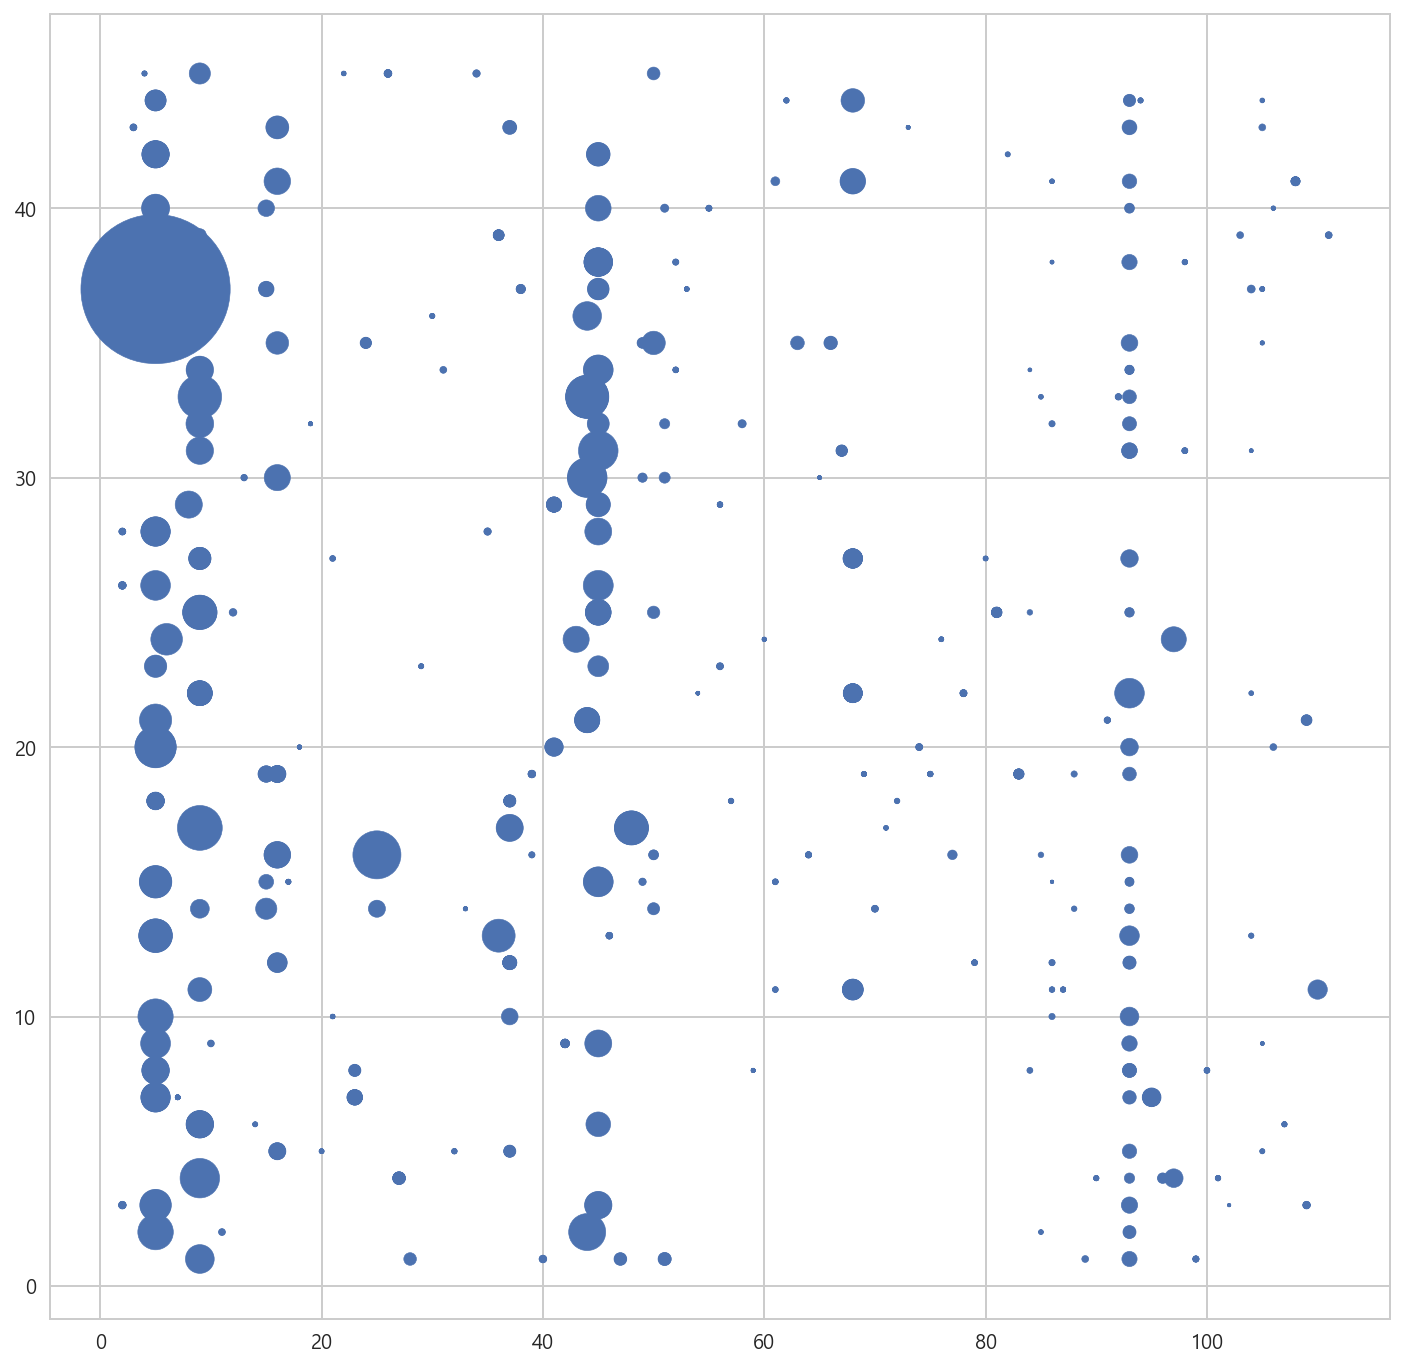

In [91]:
# 스토어, 아이템, 갯수, 요일
plt.figure(figsize=(12,12))
x = master["item_nbr"]
y1 = master["store_nbr"]
# y2 = master["DOW"]
y3 = master["units"]
plt.grid(10)
plt.scatter(x, y1, s=y3)
# plt.bar(x,,alpha=0.1)
# plt.legend()
plt.show()

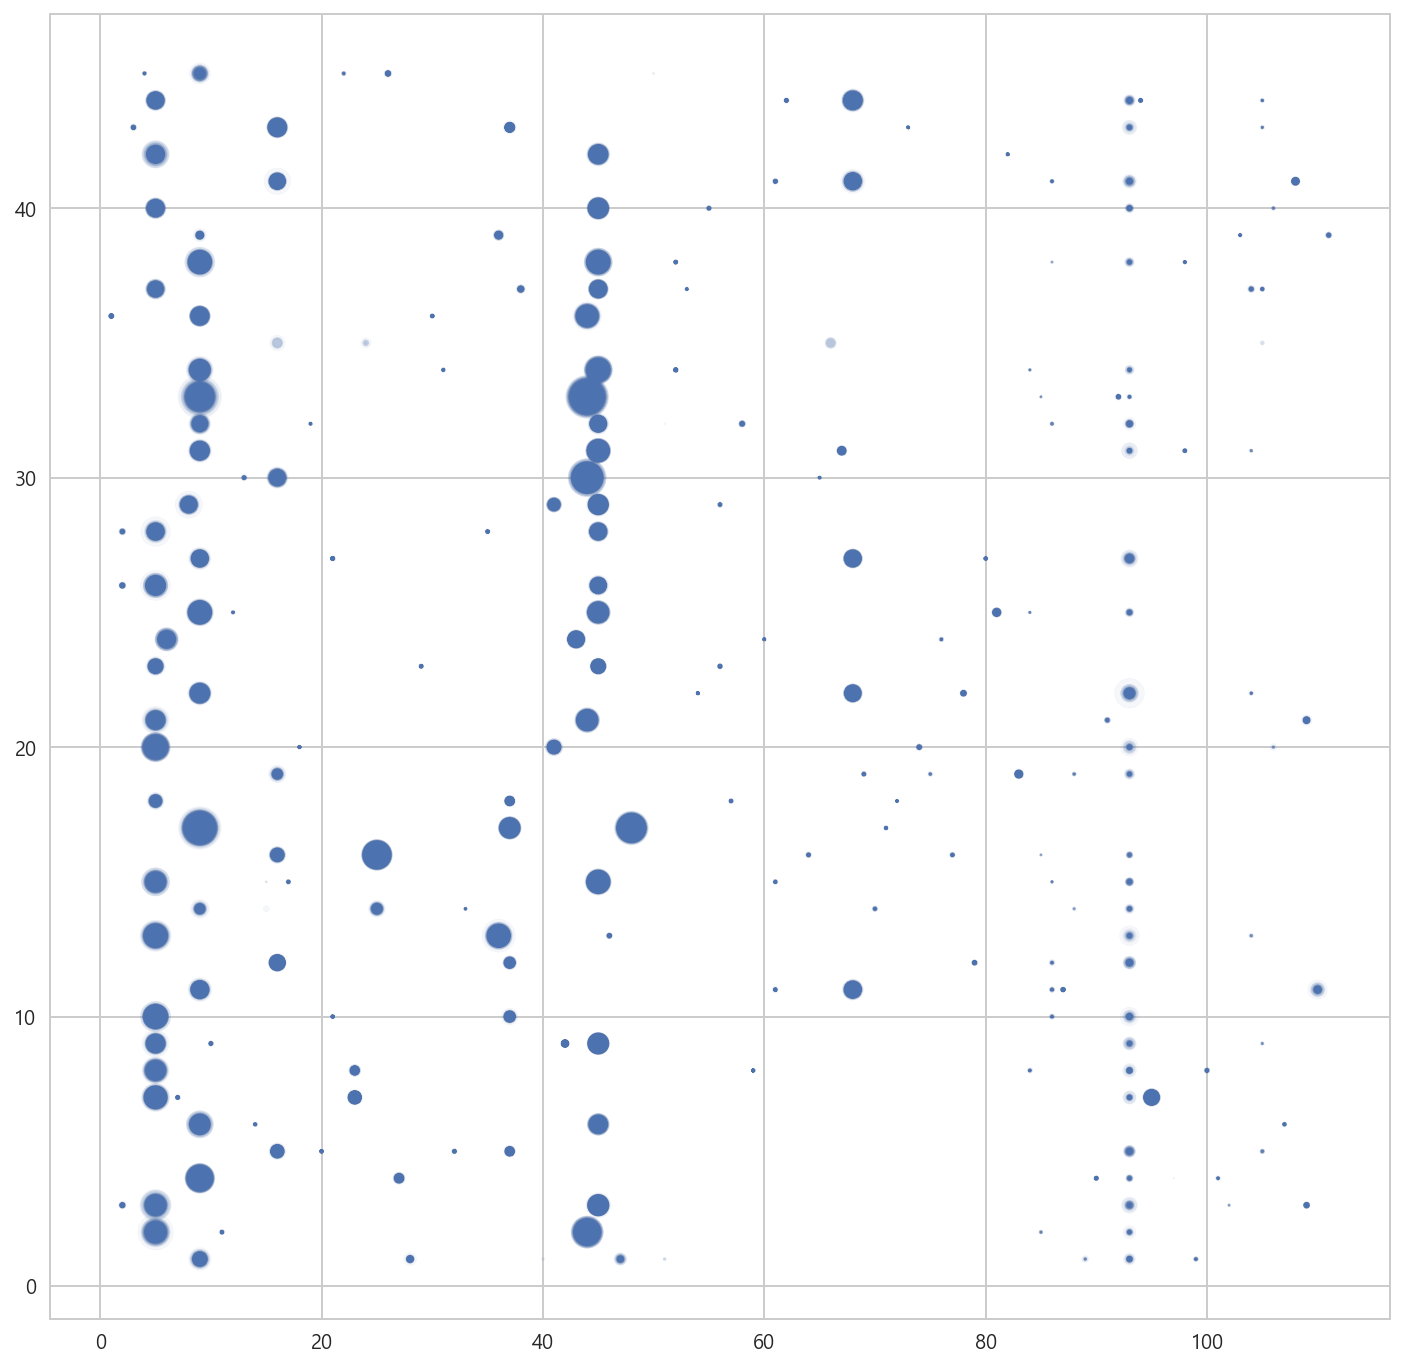

In [93]:
# 스토어, 아이템, 갯수, 요일 (빈도수가 높을수록 진하게 표시됨)

#조건설정
cond = master[master["tavg"]>65]

plt.figure(figsize=(12,12))
x = cond["item_nbr"]
y1 = cond["store_nbr"]
# y2 = cond["DOW"]
y3 = cond["units"]
plt.grid(10)
plt.scatter(x, y1, s=y3, alpha=0.05)
# plt.bar(x,,alpha=0.1)
# plt.legend()
plt.show()

### - 각 아이템넘버기준 X요일/Y판매량

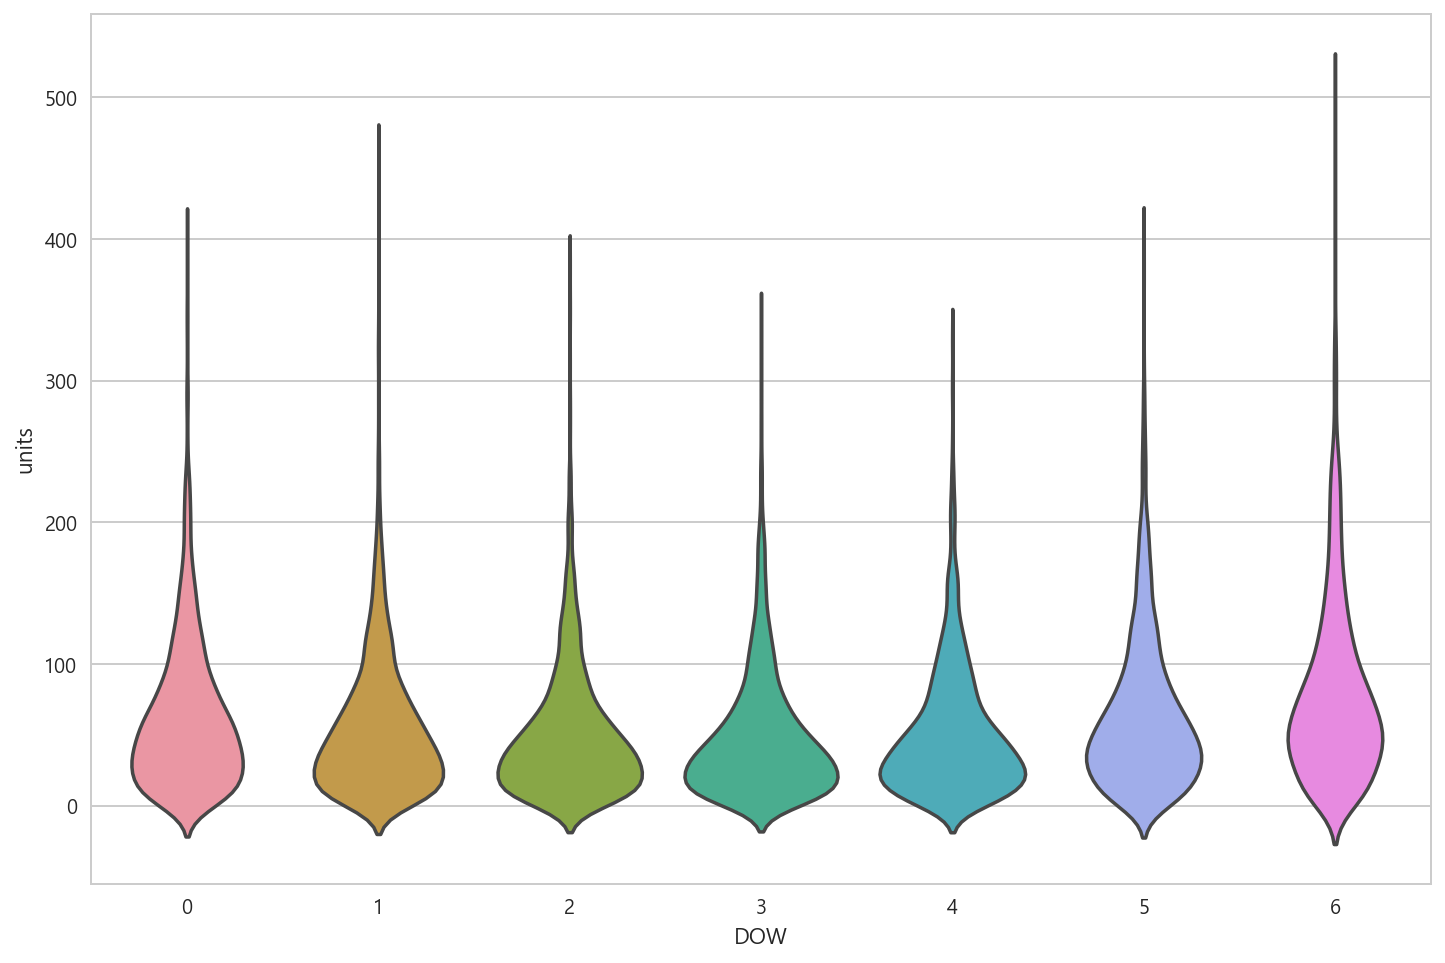

In [61]:
#대표적으로 2번아이템의 경우
item2 = master[master["item_nbr"]==9]
# item2.plot.scatter(x="preciptotal",y="units",figsize=(12,8))

fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="DOW", y="units", data=item2, inner=None)
# sns.swarmplot(ax=ax, x="DOW", y="units", data=item2, color="0.9")
plt.show()

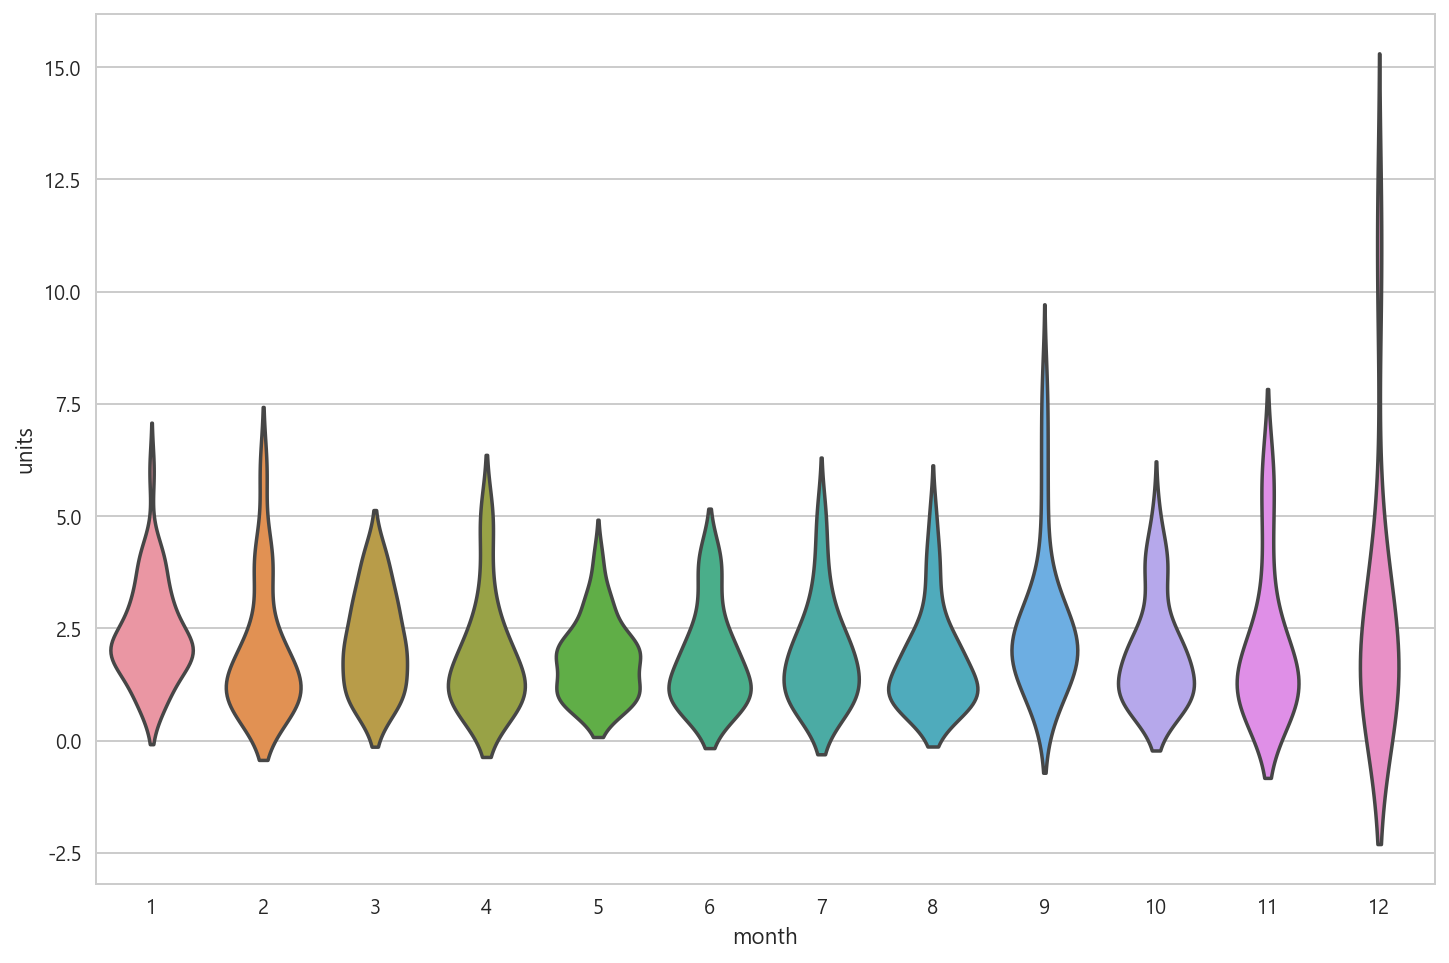

In [73]:
#각 아이템별 X월/Y판매량
item_n = master[master["item_nbr"]==11]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(ax=ax, x="month", y="units", data=item_n, inner=None)
plt.show()

TypeError: boxplot() got an unexpected keyword argument 'inner'

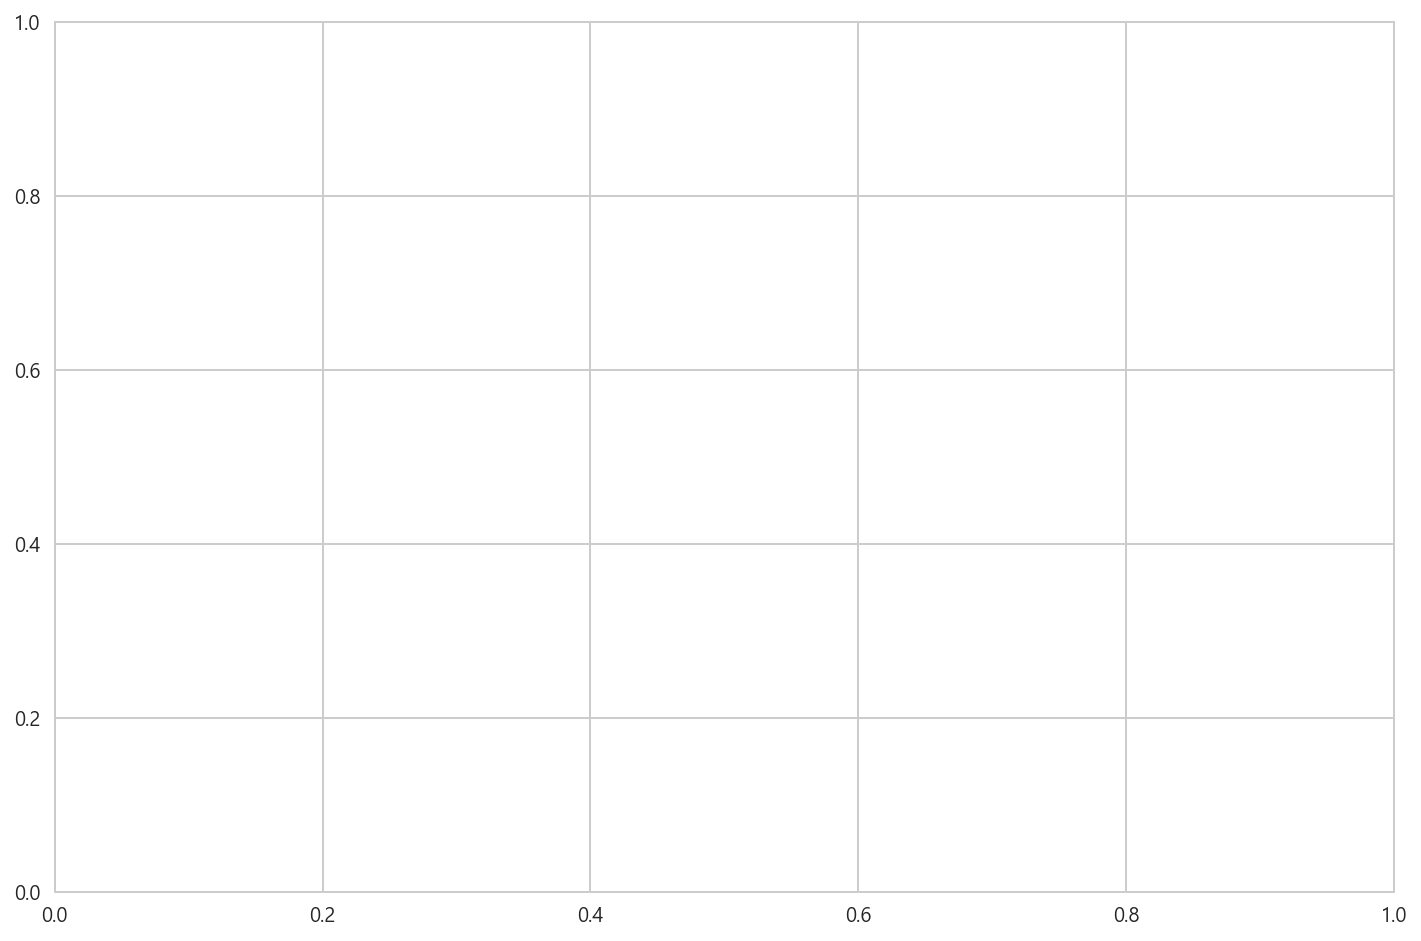

In [75]:
#각 아이템별 X월/Y판매량
item_n = master[master["item_nbr"]==10]
# master[master["item_nbr"]==12].plot.scatter(x="month",y="units",figsize=(12,8),style="hex")
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, x="month", y="units", data=item_n, inner=None)
plt.show()

In [71]:

count_code = master.groupby("codesum").size().reset_index(name="counts")
count_code.sort_values("counts", ascending=False).reset_index(drop=True)

,codesum,counts
0,,65560
1,BR,8079
2,RA,7982
3,RA BR,7522
4,BR HZ,2094
5,SN BR,1865
6,HZ,1859
7,TSRA RA BR,1415
8,TS,1411
9,TSRA,895


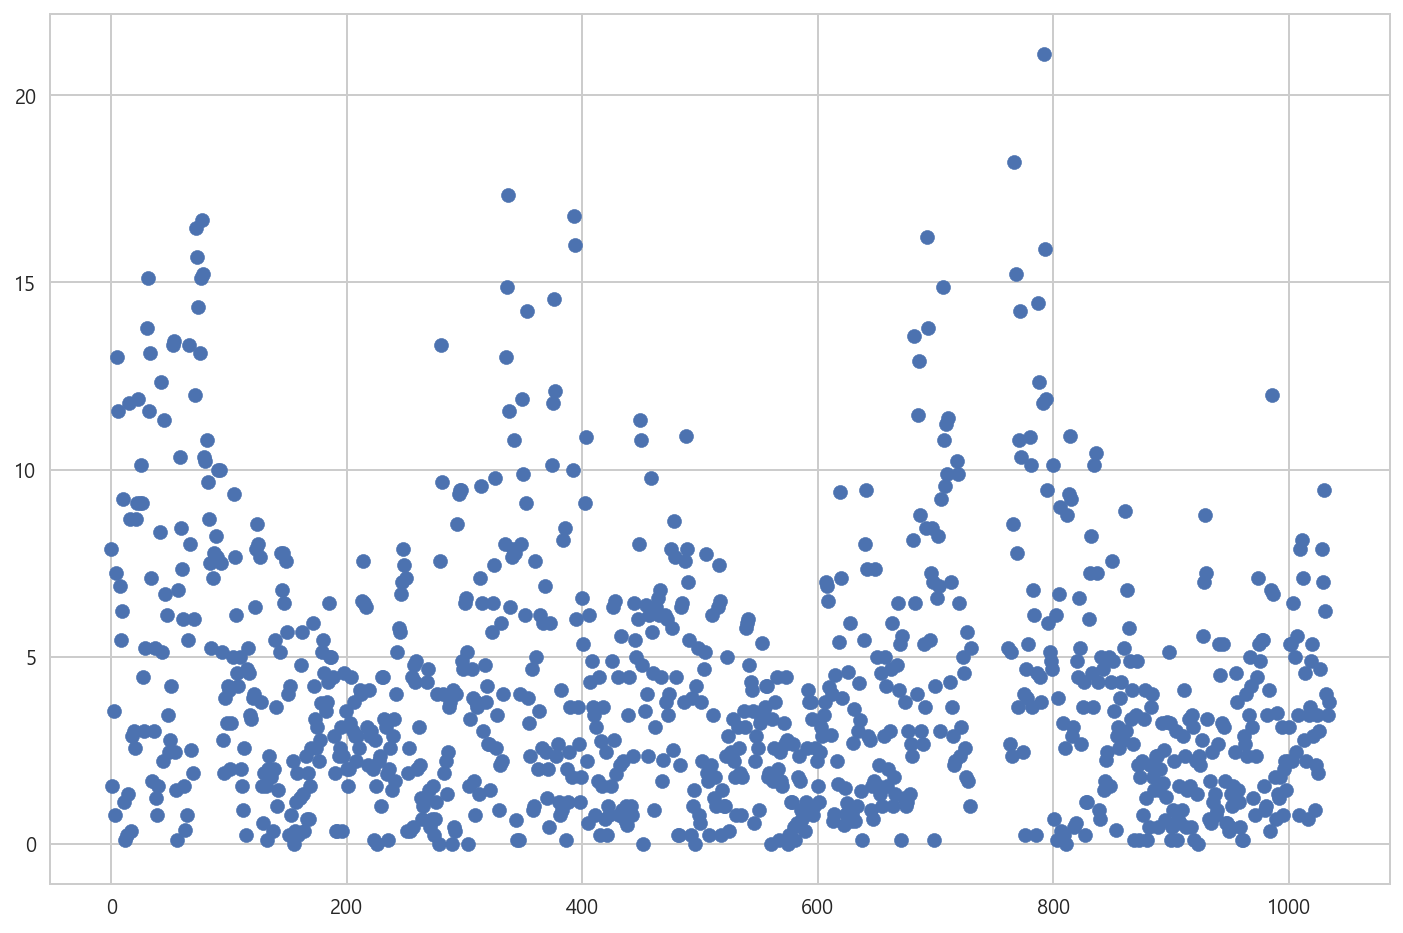

In [38]:
#전체 스테이션 평균 depart의 scatter
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_depart_avg)),abs(station_depart_avg))

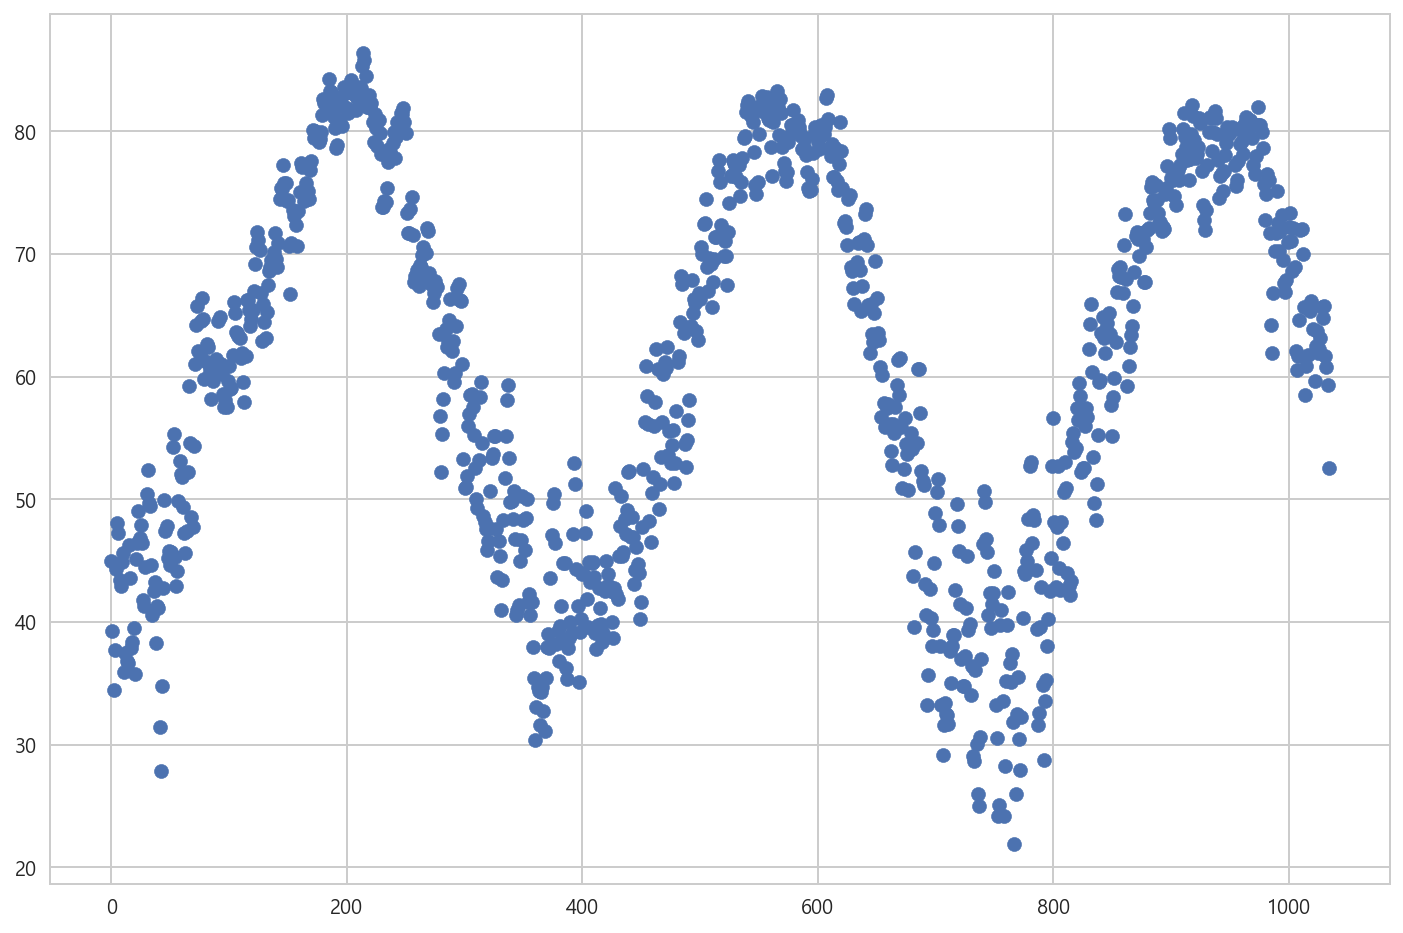

In [40]:
#전체 스테이션 평균 depart의 scatter
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_temp_avg)),abs(station_temp_avg))

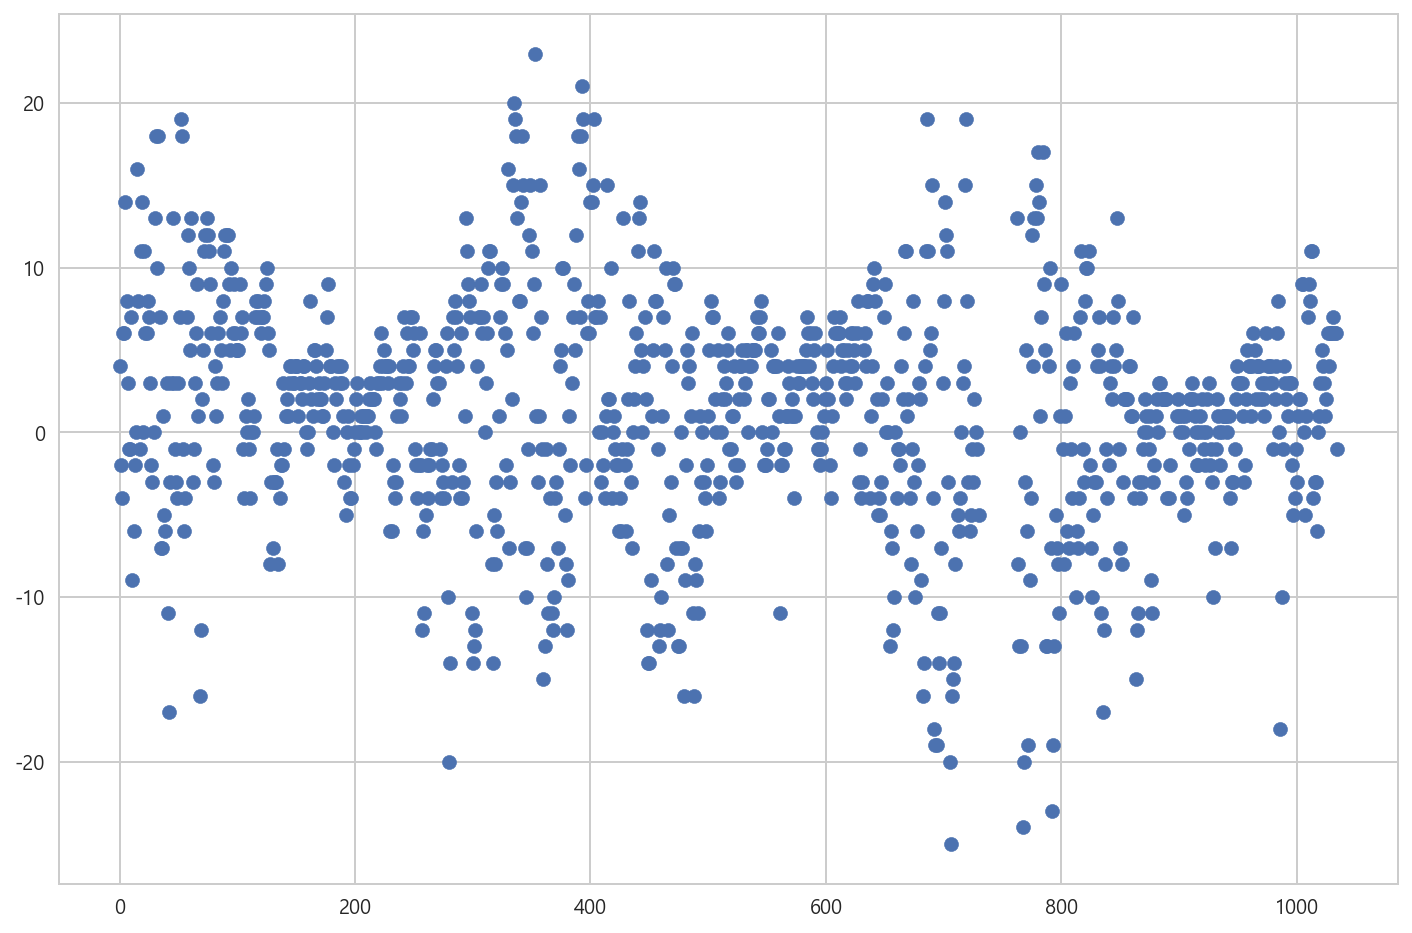

In [37]:
#일부 스테이션 depart의 분포
plt.figure(figsize=(12,8))
plt.scatter(range(len(station_depart)),station_depart[4])

In [34]:
station_depart

station_nbr,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
date,,,,,,,,,,,,,,,,,,,,
2012-01-01,NaN,16.0,9.0,4.0,NaN,0.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,5.0,16.0,NaN,NaN,4.0,10.0,NaN
2012-01-02,NaN,12.0,-1.0,-2.0,NaN,-4.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,-1.0,15.0,NaN,NaN,-2.0,-2.0,NaN
2012-01-03,NaN,-6.0,2.0,-4.0,NaN,-5.0,NaN,NaN,NaN,NaN,-18.0,NaN,NaN,5.0,-3.0,NaN,NaN,0.0,-3.0,NaN
2012-01-04,NaN,-11.0,11.0,6.0,NaN,2.0,NaN,NaN,NaN,NaN,-15.0,NaN,NaN,9.0,-8.0,NaN,NaN,5.0,8.0,NaN
2012-01-05,NaN,2.0,14.0,6.0,NaN,6.0,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,12.0,6.0,NaN,NaN,6.0,16.0,NaN
2012-01-06,NaN,10.0,19.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,16.0,4.0,NaN,NaN,16.0,24.0,NaN
2012-01-07,NaN,23.0,11.0,8.0,NaN,9.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,13.0,13.0,NaN,NaN,8.0,14.0,NaN
2012-01-08,NaN,8.0,7.0,3.0,NaN,3.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,11.0,11.0,NaN,NaN,4.0,9.0,NaN
2012-01-09,NaN,6.0,4.0,-1.0,NaN,2.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,6.0,5.0,NaN,NaN,3.0,16.0,NaN


In [ ]:
#선형회귀분석툴 StatsModel임

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())